# RNN Implementation
-------------------
Summary: A weather-based energy time series forecasting project, using recurrent neural network with two recurrent layers, one convolution layer,
dropout, adam optimizer with learning rate and relu activation functions. Model R-squared is 0.77

In [ ]:
# import modules
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
# https://drive.google.com/file/d/1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V/view?usp=sharing
!gdown 1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V

Downloading...
From: https://drive.google.com/uc?id=1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V
To: /content/BDL_cleanweather_energy (1).csv
100% 7.38M/7.38M [00:00<00:00, 40.8MB/s]


In [ ]:
import pandas as pd
df = pd.read_csv('BDL_cleanweather_energy (1).csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


# **Sorting:**
Sort the data from oldest to newest.

In [ ]:
# check the oldest date and newest date before sorting
print("the oldest date is", df['Datetime'].min())
print("the newest date is", df['Datetime'].max())

the oldest date is 2011-01-01 00:00:00
the newest date is 2021-12-31 23:00:00


In [ ]:
# sort df based on the Datetime
df = df.sort_values(by=df.columns[0])

In [ ]:
# check head
df.head(n=5)

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
8760,2011-01-01 00:00:00,3053.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
8761,2011-01-01 01:00:00,2892.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
8762,2011-01-01 02:00:00,2774.0,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0
8763,2011-01-01 03:00:00,2710.0,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0
8764,2011-01-01 04:00:00,2698.0,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0


In [ ]:
# check tail
df.tail(n=5)

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
78855,2021-12-31 19:00:00,3310.60,48.0,45.0,89.29,190.0,7.0,0.0,29.95,1014.2,6.0
78856,2021-12-31 20:00:00,3148.00,48.0,46.0,92.74,190.0,5.0,0.0,29.95,1013.8,5.0
78857,2021-12-31 21:00:00,2988.93,48.0,46.0,92.74,170.0,7.0,0.0,29.94,1013.5,5.0
78858,2021-12-31 22:00:00,2793.70,46.9,46.4,100.00,180.0,7.0,0.0,29.94,1013.8,5.0
78859,2021-12-31 23:00:00,2629.35,48.0,46.0,92.74,160.0,5.0,0.0,29.94,1013.3,4.0


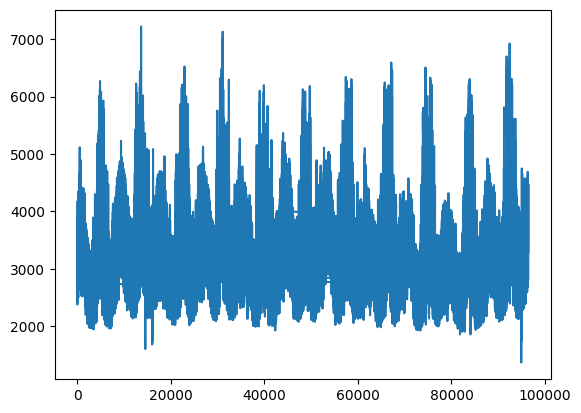

In [ ]:
# take a peek at the plot before doing any feature engineering
df['Demand'].plot()
plt.show()

Even if I see some of the noise, still looks good. Demand seem to have patterns.

# **Cleaning:**
Describe and impute (or drop) the missing values using an appropriate method. At this time, you are welcome to perform feature engineering (optional).

In [ ]:
# let's check how many rows are missing in each column
df.isna().sum()

Datetime      0
Demand        0
BDL_tmpf    267
BDL_dwpf    267
BDL_relh    267
BDL_drct    267
BDL_sknt    267
BDL_p01i    267
BDL_alti    267
BDL_mslp    267
BDL_vsby    267
dtype: int64

let me see how much the missing values takes out of the total rows.

In [ ]:
print("the portion of missing values out of total rows is \n", df.isna().sum()/len(df))

the portion of missing values out of total rows is 
 Datetime    0.000000
Demand      0.000000
BDL_tmpf    0.002769
BDL_dwpf    0.002769
BDL_relh    0.002769
BDL_drct    0.002769
BDL_sknt    0.002769
BDL_p01i    0.002769
BDL_alti    0.002769
BDL_mslp    0.002769
BDL_vsby    0.002769
dtype: float64


this is negligible. I am going to drop mising values.

In [ ]:
df = df.dropna(axis = 0)
# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96160 entries, 8760 to 78859
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96160 non-null  object 
 1   Demand    96160 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.8+ MB


In [ ]:
# also drop Datetime column, as it is now sorted and does not need to go into model
df.drop(['Datetime'], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96160 entries, 8760 to 78859
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Demand    96160 non-null  float64
 1   BDL_tmpf  96160 non-null  float64
 2   BDL_dwpf  96160 non-null  float64
 3   BDL_relh  96160 non-null  float64
 4   BDL_drct  96160 non-null  float64
 5   BDL_sknt  96160 non-null  float64
 6   BDL_p01i  96160 non-null  float64
 7   BDL_alti  96160 non-null  float64
 8   BDL_mslp  96160 non-null  float64
 9   BDL_vsby  96160 non-null  float64
dtypes: float64(10)
memory usage: 8.1 MB


<ipython-input-113-eae641ad735c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Datetime'], inplace=True, axis=1)


In [ ]:
# I need the Demand column to be at the last column of the df.
Y = df[['Demand']]
X = df.drop(axis=1, columns=['Demand'])
df = pd.concat([X, Y], axis=1, sort=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96160 entries, 8760 to 78859
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BDL_tmpf  96160 non-null  float64
 1   BDL_dwpf  96160 non-null  float64
 2   BDL_relh  96160 non-null  float64
 3   BDL_drct  96160 non-null  float64
 4   BDL_sknt  96160 non-null  float64
 5   BDL_p01i  96160 non-null  float64
 6   BDL_alti  96160 non-null  float64
 7   BDL_mslp  96160 non-null  float64
 8   BDL_vsby  96160 non-null  float64
 9   Demand    96160 non-null  float64
dtypes: float64(10)
memory usage: 8.1 MB


Cool! now proceed with 3D tensor

# **Process as a 3D tensor:**
Process the data as a 3D tensor with a lookback of your choice (use a value greater than or equal to 12).

In [ ]:
# prep data for modeling (multivariate)
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1] # split x and y. X is every column except the last one, and y is the last column
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y) # now X and y are array

In [ ]:
# all we need to do is decide on is n_steps (what our lookback period is)
n_steps = 20
raw_seq = np.array(df) #make sure your data is stored as a numpy array!
# let's ignore the date column and just use the temperature data
X, y = split_sequences(raw_seq, n_steps)

In [ ]:
# split the data into train and test partitions
# 80% of the data for train, and 20% for validation
train_pct_index = int(0.8 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [ ]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(96141, 20, 9) (76912, 20, 9) (19229, 20, 9)
(96141,) (76912,) (19229,)


In [ ]:
n_steps = X_train.shape[1] # lookback
n_features = X_train.shape[2] # columns

print(n_steps, n_features)

20 9


In [ ]:
# standardize X_train because it actually helps the model results a LOT
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(X_train.shape)

# **Model Architecure:**
You must use a model with:
* at least two recurrent layers
* at least one convolution layer
* dropout (recurrent or between Dense layers)
* appropriate activation functions

In [ ]:
# now let's build a model

# define
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

adam_optimizer = Adam(learning_rate=0.001)

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(n_steps,n_features))) # one Conv layer
model.add(MaxPooling1D(2))
model.add(LSTM(64, return_sequences=True, activation='relu', recurrent_dropout=0.1)) # first LSTM layer
model.add(LSTM(32, activation='relu', recurrent_dropout=0.1)) # second LSTM layer
model.add(Dropout(0.1)) # dropout
model.add(Dense(1, activation='linear')) # this is regression problem so the activation function as linear
model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', # minimize validation loss
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 18, 64)            1792      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 9, 64)             0         
 g1D)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 9, 64)             33024     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                      

## Fit the model

In [ ]:
model.fit(X_train, y_train,
                    validation_split=0.2,
                    callbacks=[es],
                    epochs=1000,
                    batch_size=100,
                    shuffle=True,
                    verbose=1)

Epoch 1/1000
616/616 [==============================] - 32s 40ms/step - loss: 1798688.7500 - mae: 1008.5682 - val_loss: 670567.5000 - val_mae: 659.8394
Epoch 2/1000
616/616 [==============================] - 24s 38ms/step - loss: 846633.9375 - mae: 723.5854 - val_loss: 567108.6250 - val_mae: 568.6128
Epoch 3/1000
616/616 [==============================] - 25s 40ms/step - loss: 764080.6875 - mae: 688.2245 - val_loss: 584146.1250 - val_mae: 604.1768
Epoch 4/1000
616/616 [==============================] - 24s 39ms/step - loss: 725716.5625 - mae: 672.2763 - val_loss: 624091.0625 - val_mae: 638.3975
Epoch 5/1000
616/616 [==============================] - 24s 39ms/step - loss: 720219.3125 - mae: 669.0965 - val_loss: 546792.9375 - val_mae: 577.4673
Epoch 6/1000
616/616 [==============================] - 23s 37ms/step - loss: 707148.0625 - mae: 661.7789 - val_loss: 525628.8750 - val_mae: 569.2214
Epoch 7/1000
616/616 [==============================] - 24s 39ms/step - loss: 677168.9375 - mae: 6

## Evaluate the model

### Train data

In [ ]:
# predict train Data
pred_train = model.predict(X_train)

# error metrics
mae_train = mean_absolute_error(y_train, pred_train)
r2_train= r2_score(y_train, pred_train)

print("MAE for train data is", mae_train)
print("R2 for train data is", r2_train)

2404/2404 [==============================] - 15s 6ms/step
MAE for train data is 387.21490100200504
R2 for train data is 0.5988968197484141


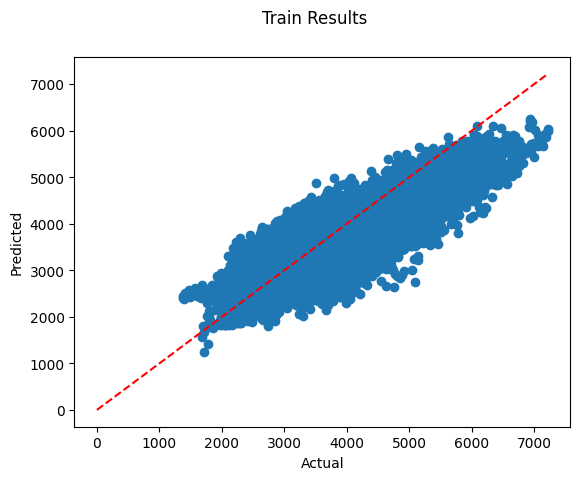

In [ ]:
actual = y_train # the actual
plt.scatter(x=actual, y=pred_train)
plt.plot([0, max(actual)], [0, max(actual)], color='red', linestyle='--') # 45 degrees diagonal line
plt.suptitle('Train Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

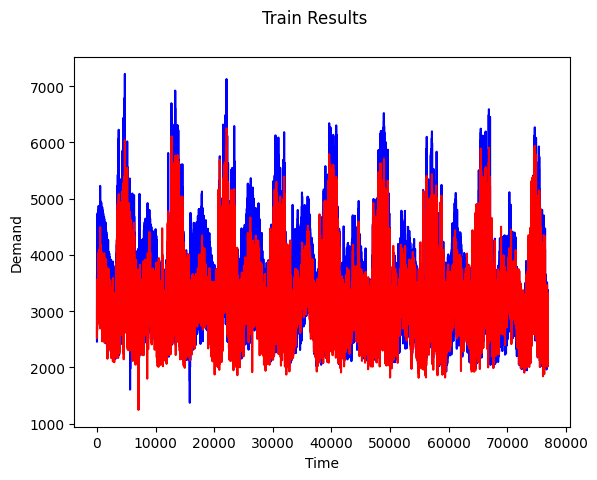

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_train.shape[0]), y_train, color='blue') # actual data
plt.plot(np.arange(X_train.shape[0]), pred_train, color='red') # predicted data
plt.suptitle('Train Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

### Test data

In [ ]:
# predict test results
pred = model.predict(X_test)

# Calculate metrics
mae_test = mean_absolute_error(y_test, pred)
r2_test = r2_score(y_test, pred)

print("MAE for test data is", mae_test)
print("R2 for test data is", r2_test)

601/601 [==============================] - 3s 6ms/step
MAE for test data is 315.3625534962146
R2 for test data is 0.691390207756354


error metrics is better than training dataset.

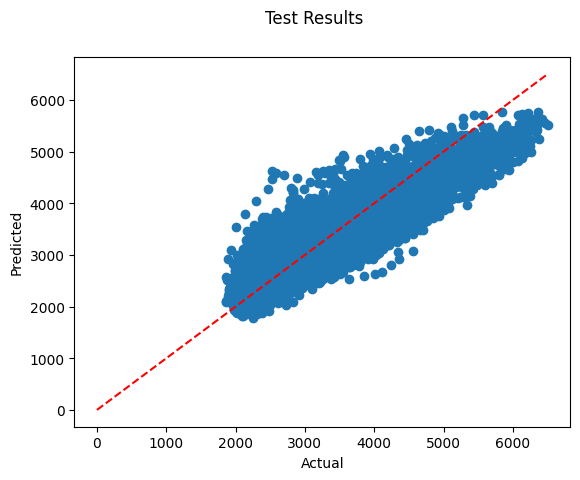

In [ ]:
actual = y_test # the actual
plt.scatter(x=actual, y=pred)
#add 45 deg line
plt.plot([0, max(actual)], [0, max(actual)], color='red', linestyle='--') # 45 degrees diagonal line
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

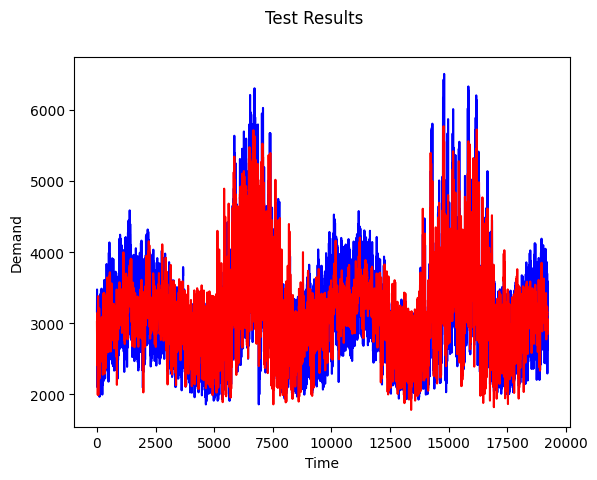

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

Also plots look better than training.

# **Experiments:**
Freeze the model architecutre and perform a *walk-forward validation* where:
* the first 50k samples predict the remaining ~46k samples
* the first 80k samples predict the remaining ~16k samples

Walk-forward validation is very common to use on the job - it shows how your model (ideally) gets better over time as it gets more data to use. Use subheads

## the first 50k samples predict the remaining ~46k samples

In [ ]:
# subset 50k samples for training and remaining as test
X_train_50, X_test_50 = X[:50000], X[50000:]
y_train_50, y_test_50 = y[:50000], y[50000:]
# check out the shape
print(X.shape, X_train_50.shape, X_test_50.shape)
print(y.shape, y_train_50.shape, y_test_50.shape)

(96141, 20, 9) (50000, 20, 9) (46141, 20, 9)
(96141,) (50000,) (46141,)


In [ ]:
# Fit the model on the training data
model.fit(X_train_50, y_train_50)
# Make predictions on the test data
pred_50 = model.predict(X_test_50)

## the first 80k samples predict the remaining ~16k samples

In [ ]:
# subset 80k for training and the remaining for test
X_train_80, X_test_80 = X[:80000], X[80000:]
y_train_80, y_test_80 = y[:80000], y[80000:]
print(X.shape, X_train_80.shape, X_test_80.shape)
print(y.shape, y_train_80.shape, y_test_80.shape)

(96141, 20, 9) (80000, 20, 9) (16141, 20, 9)
(96141,) (80000,) (16141,)


In [ ]:
# Fit the model on the training data
model.fit(X_train_80, y_train_80)
# Make predictions on the test data
pred_80 = model.predict(X_test_80)

# **Evaluation**
Evaluate your model for each of these experiments - hopefully, your model should improve as you give it more data to use! But that depends on your choice of architecture. You should have:
* quantitative error metrics (mean absolute error and others)
* scatterplots of actual vs. predicted
* time series plots of actual vs. predicted

You should also compare to baseline model like persistence (assume today's energy usage is the same as yesterday's - requires you to shift by 24... ask on discussion board if questions!) or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem!)

## the first 50k samples predict the remaining ~46k samples

MAE for the first 50k samples is:  325.99239775404806


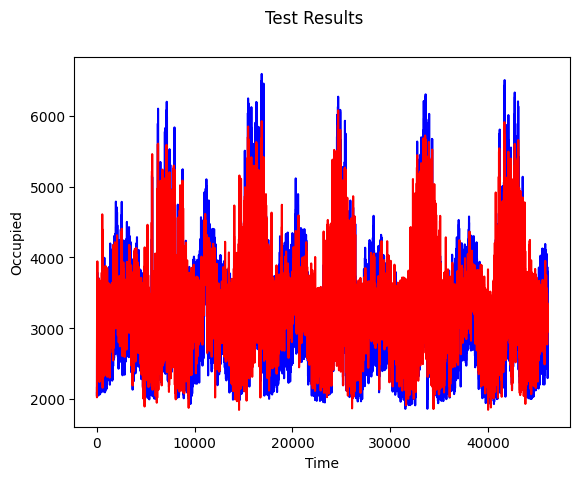

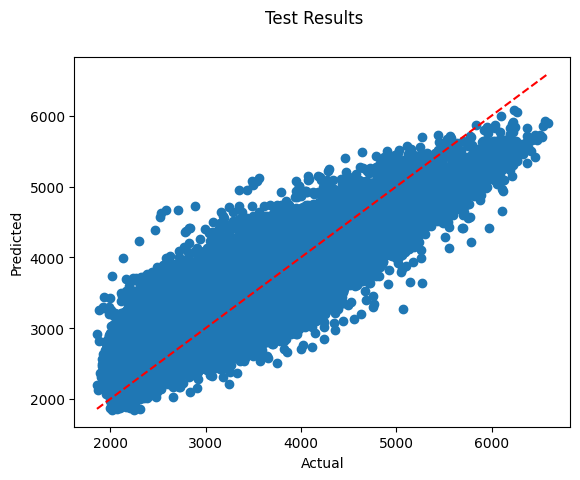

In [ ]:
# MAE
print('MAE for the first 50k samples is: ', mean_absolute_error(y_test_50, pred_50))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test_50.shape[0]), y_test_50, color='blue') # actual data
plt.plot(np.arange(X_test_50.shape[0]), pred_50, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# scatterplots
actual_50 = y_test_50 # the actual
plt.scatter(x=actual_50, y=pred_50)
plt.plot([min(actual_50), max(actual_50)], [min(actual_50), max(actual_50)], color='red', linestyle='--')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [ ]:
r_squared_50 = r2_score(y_test_50, pred_50)
print("R-squared is:", r_squared_50)

R-squared is: 0.6820533340755076


For the 50k samples, R-squared is .68 and MAE is 325. Let me compare the 80k samples later.

## the first 80k samples predict the remaining ~16k samples

505/505 [==============================] - 3s 6ms/step
MAE for the first 80k samples is:  326.39626627684834


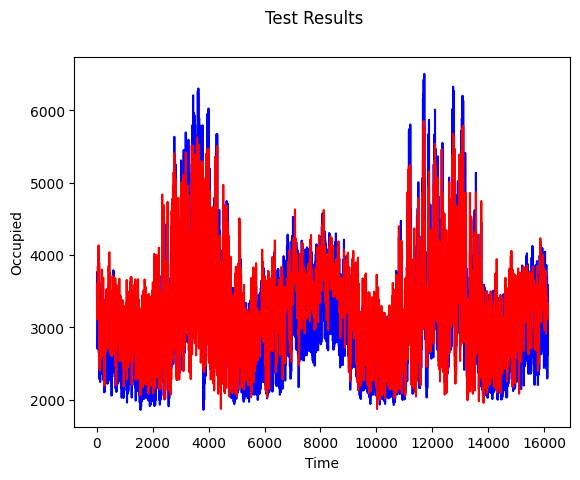

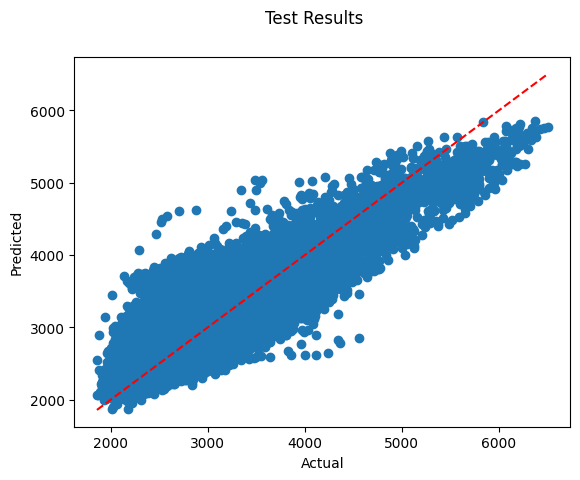

In [ ]:
# make a prediction
pred_80 = model.predict(X_test_80)# the pred

# MAE
print('MAE for the first 80k samples is: ', mean_absolute_error(y_test_80, pred_80))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test_80.shape[0]), y_test_80, color='blue') # actual data
plt.plot(np.arange(X_test_80.shape[0]), pred_80, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# scatterplots
actual_80 = y_test_80 # the actual
plt.scatter(x=actual_80, y=pred_80)
plt.plot([min(actual_80), max(actual_80)], [min(actual_80), max(actual_80)], color='red', linestyle='--')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [ ]:
r_squared_80 = r2_score(y_test_80, pred_80)
print("R-squared for test is:", r_squared_80)

R-squared for test is: 0.6941848841880847


For the 80k samples, the R-squared is 0.69 which is a bit better than 50k one. The MAE is 326 which is not that different than 50k samples.

## compare to baseline model like persistence
(assume today's energy usage is the same as yesterday's - requires you to shift by 24... ask on discussion board if questions!) or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem!)

In [ ]:
# baseline model - shift 24 so that compare daily demand.
df['Baseline'] = df['Demand'].shift(24)
df.head()

,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,Demand,Baseline
8760,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,3053.0,NaN
8761,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,2892.0,NaN
8762,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0,2774.0,NaN
8763,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0,2710.0,NaN
8764,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0,2698.0,NaN


In [ ]:
# I standardized the X and y so I need to re-define the X and y here as it is.
Y_base = df[['Demand']]
X_base = df.drop(axis=1, columns=['Demand'])
# now convert to np array so that easily compare
Y_base = np.array(Y_base)
X_base = np.array(X_base)

In [ ]:
# also, split to 80 training and 20 test just like I did above.
train_pct_index = int(0.8 * len(X))
X_train_base, X_test_base = X_base[:train_pct_index], X_base[train_pct_index:]
y_train_base, y_test_base = Y_base[:train_pct_index], Y_base[train_pct_index:]

In [ ]:
# set the baseline for y_test_base
y_test_baseline = df['Baseline'].tail(y_test_base.shape[0]) # returns the last Y.shape[0] rows from the 'Baseline' column

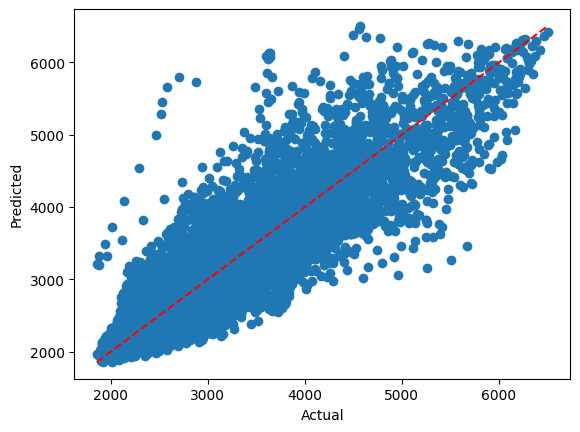

In [ ]:
# show scatterplots of actual vs. predicted for train and test
pred = y_test_baseline # the pred
actual = y_test_base # the actual
plt.scatter(x=actual, y=pred)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--') # 45 degrees red line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Looks pretty good! predicts are well aligned to the red line.

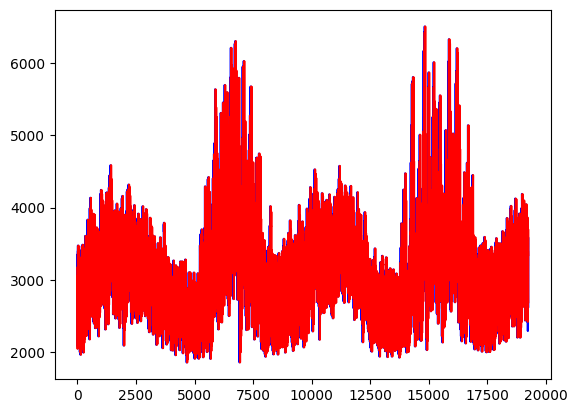

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test_base.shape[0]), y_test_base, color='blue') # actual data
plt.plot(np.arange(X_test_base.shape[0]), pred, color='red') # predicted data
plt.show()

From the plots, it looks good. Now look further on the error metrics

In [ ]:
# MAE for the baseline
mean_absolute_error(y_test_base, pred)

234.8914098088113

In [ ]:
# R squared for the baseline
r_squared = r2_score(y_test_base, pred)
print("R-squared:", r_squared)

R-squared: 0.7696722522367805


Hmm.. MAE and R squared are worse than those experiments above. It means, my model for the experiments outperformed than the baseline! my model is successful!

# **Conclusions**

* The learning rate matters!!! I can't even compare the model result without learning rate and with learning rate. MAE is much much better with the learning rate = 0.001
* In this case, having less samples made the model result better. I thought having more sample to train makes the model result better, but not in this case. But there was no meaningful difference between the two samples. Next time, I would like to tune parameters and layers to see if the model performance gets different.
* It took a lot of time to fit the model. I tried batch size 50 at first, but thinking that I actually have 96k in total, I increased the batch size as 100. Still, it took 30 min to run the whole script. Maybe later, I will try bigger batch size.
* This is the second most difficult assingment to me. The first one was Conv network to classify the images... Still, the difference between the Conv one and this is that I can compare the model result with the baseline more easily.
* Standardizing X train helps the model result better. Before standardizing, the MAE was arond 1,000 but now it has been reduced drastically as 300 something.